In [1]:
import sqlite3
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from nltk.tokenize import TweetTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

In [2]:
conn = sqlite3.connect('../redditPosts.sqlite')
cur = conn.cursor()

In [3]:
cur.execute('''SELECT subreddit FROM Posts GROUP BY subreddit ORDER BY (COUNT(id))''')
subreddits = list(map(lambda x: x[0], cur.fetchall()))

subreddits

['Superstonks',
 'finance',
 'options',
 'pennystocks',
 'GME',
 'CryptoCurrency',
 'dogecoin',
 'wallstreetbets']

In [4]:
conn = sqlite3.connect('../redditPosts.sqlite')
query = '''SELECT * FROM Posts P JOIN PostBodyAndScore B ON P.id = B.id 
           WHERE B.body != "[removed]" AND B.body != "[deleted]"'''
df = pd.read_sql(sql=query, con=conn)
df.head(2)

,id,subreddit,title,author,url,created,ext_link,id,body,score,upvote_ratio
0,kobbka,finance,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,https://www.reddit.com/r/finance/comments/kobb...,1609507913,https://www.fintechinshorts.com/mogo-establish...,kobbka,,1,1.0
1,koe39g,finance,Standard Capital: Partners with SolidBlock Sta...,fintechinshorts,https://www.reddit.com/r/finance/comments/koe3...,1609518689,https://www.fintechinshorts.com/standard-capit...,koe39g,,1,1.0


In [5]:
df.shape

(226890, 11)

## Selecting subreddit with complete datasets

In [6]:
df = df[
        (df.subreddit == 'finance') |
        (df.subreddit == 'options') |
        (df.subreddit == 'pennystocks') |
        (df.subreddit == 'GME')]

## Plot the histogram of score for each subreddit

finance 1.0 1.0 240.2
options 0.0 1.0 44.0
pennystocks 1.0 4.0 154.0
GME 0.0 12.0 465.0


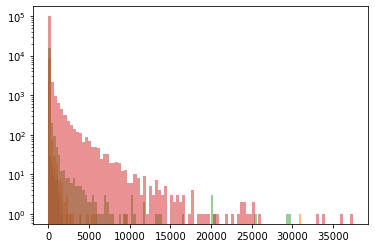

In [7]:
for sr in df.subreddit.unique():
    scores = df[df.subreddit == sr].score.values
    plt.hist(scores, 100, alpha=0.5)
    print(sr, '%.1f %.1f %.1f' % (np.percentile(scores, 5), np.percentile(scores, 50), np.percentile(scores, 95)))
plt.yscale('log')
plt.show()

## Defining the popular posts for binary classification

In [8]:
df_finance     = df[df.subreddit == 'finance']
df_options     = df[df.subreddit == 'options']
df_pennystocks = df[df.subreddit == 'pennystocks']
df_gme         = df[df.subreddit == 'GME']

In [9]:
df_finance['popular'] = 0
df_options['popular'] = 0
df_pennystocks['popular'] = 0
df_gme['popular'] = 0

<ipython-input-9-93d1be54b864>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_finance['popular'] = 0
<ipython-input-9-93d1be54b864>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_options['popular'] = 0
<ipython-input-9-93d1be54b864>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [10]:
df_finance.loc[df_finance['score'] > np.percentile(df_finance.score.values, 95), 'popular'] = 1
df_options.loc[df_options['score'] > np.percentile(df_options.score.values, 95), 'popular'] = 1
df_pennystocks.loc[df_pennystocks['score'] > np.percentile(df_pennystocks.score.values, 95), 'popular'] = 1
df_gme.loc[df_gme['score'] > np.percentile(df_gme.score.values, 95), 'popular'] = 1

/Users/dutomo/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [11]:
del df
df = pd.concat([df_finance, df_options, df_pennystocks, df_gme], ignore_index=True)
df.head(2)

,id,subreddit,title,author,url,created,ext_link,id,body,score,upvote_ratio,popular
0,kobbka,finance,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,https://www.reddit.com/r/finance/comments/kobb...,1609507913,https://www.fintechinshorts.com/mogo-establish...,kobbka,,1,1.0,0
1,koe39g,finance,Standard Capital: Partners with SolidBlock Sta...,fintechinshorts,https://www.reddit.com/r/finance/comments/koe3...,1609518689,https://www.fintechinshorts.com/standard-capit...,koe39g,,1,1.0,0


In [12]:
df.popular.unique()

array([0, 1])

## Dropping unnecessary columns

In [13]:
df.drop(['id','url'], axis=1, inplace=True)
df.head(2)

,subreddit,title,author,created,ext_link,body,score,upvote_ratio,popular
0,finance,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,1609507913,https://www.fintechinshorts.com/mogo-establish...,,1,1.0,0
1,finance,Standard Capital: Partners with SolidBlock Sta...,fintechinshorts,1609518689,https://www.fintechinshorts.com/standard-capit...,,1,1.0,0


## Running sentiment analysis

In [14]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [15]:
def neg_sentiment(inp):
    return analyzer.polarity_scores(inp)['neg']

def pos_sentiment(inp):
    return analyzer.polarity_scores(inp)['pos']

def neu_sentiment(inp):
    return analyzer.polarity_scores(inp)['neu']

def comp_sentiment(inp):
    return analyzer.polarity_scores(inp)['compound']

df['pos_sent'] = df['title'].apply(pos_sentiment)
df['neg_sent'] = df['title'].apply(neg_sentiment)
df['neu_sent'] = df['title'].apply(neu_sentiment)
df['comp_sent'] = df['title'].apply(comp_sentiment)

## Transforming time info

In [16]:
df['posting_time'] = df['created'].apply(dt.datetime.fromtimestamp)
df.drop('created', axis=1, inplace=True)
df.head(2)

,subreddit,title,author,ext_link,body,score,upvote_ratio,popular,pos_sent,neg_sent,neu_sent,comp_sent,posting_time
0,finance,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,https://www.fintechinshorts.com/mogo-establish...,,1,1.0,0,0.000,0.0,1.000,0.0000,2021-01-01 08:31:53
1,finance,Standard Capital: Partners with SolidBlock Sta...,fintechinshorts,https://www.fintechinshorts.com/standard-capit...,,1,1.0,0,0.096,0.0,0.904,0.1531,2021-01-01 11:31:29


In [17]:
df['posting_year'] = df['posting_time'].dt.year
df['posting_month'] = df['posting_time'].dt.month
df['posting_date'] = df['posting_time'].dt.day

def to_hour(inp):
    return inp.hour + (inp.minute/60.) + (inp.second/3600.)

df['posting_hour'] = df['posting_time'].apply(to_hour)

In [18]:
def weekday(inp):
    return inp.weekday()

df['posting_day'] = df['posting_time'].apply(weekday)

In [19]:
df = pd.concat([df, pd.get_dummies(df.posting_day, prefix='posting_day', drop_first=True)], axis=1)
df.drop('posting_day', axis=1, inplace=True)

In [20]:
df.drop('posting_time', axis=1, inplace=True)
df.head(2)

,subreddit,title,author,ext_link,body,score,upvote_ratio,popular,pos_sent,neg_sent,...,posting_year,posting_month,posting_date,posting_hour,posting_day_1,posting_day_2,posting_day_3,posting_day_4,posting_day_5,posting_day_6
0,finance,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,https://www.fintechinshorts.com/mogo-establish...,,1,1.0,0,0.000,0.0,...,2021,1,1,8.531389,0,0,0,1,0,0
1,finance,Standard Capital: Partners with SolidBlock Sta...,fintechinshorts,https://www.fintechinshorts.com/standard-capit...,,1,1.0,0,0.096,0.0,...,2021,1,1,11.524722,0,0,0,1,0,0


## Extracting the external link

In [21]:
image_file_formats = ['ai','bmp','gif','ico','jpg','jpeg','png','ps','psd','svg','tif','tiff']
video_file_formats = ['.3g2','3gp','avi','flv','h264','m4v','mkv','mov','mp4','mpg','mpeg','rm','swf','vob','wmv']

In [22]:
def get_ext_media(inp):
    if (inp == None) or (inp == 0):
        last_term = 'None'
    else:
        last_term = inp.split('.')[-1]
        
    if (last_term in image_file_formats) or (last_term in video_file_formats):
        out = 1
    else:
        out = 0
    return out

df['ext_link_media'] = df['ext_link'].apply(get_ext_media)

In [23]:
def get_ext_web(inp):
    if (inp == None) or (inp == 0):
        last_term = 'None'
    else:
        last_term = inp.split('.')[-1]

    if (last_term not in image_file_formats+video_file_formats) and (last_term != 'None'):
        out = 1
    else:
        out = 0
    return out

df['ext_link_web'] = df['ext_link'].apply(get_ext_web)

In [24]:
df.drop('ext_link', axis=1, inplace=True)

In [25]:
df.head(2)

,subreddit,title,author,body,score,upvote_ratio,popular,pos_sent,neg_sent,neu_sent,...,posting_date,posting_hour,posting_day_1,posting_day_2,posting_day_3,posting_day_4,posting_day_5,posting_day_6,ext_link_media,ext_link_web
0,finance,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,,1,1.0,0,0.000,0.0,1.000,...,1,8.531389,0,0,0,1,0,0,0,1
1,finance,Standard Capital: Partners with SolidBlock Sta...,fintechinshorts,,1,1.0,0,0.096,0.0,0.904,...,1,11.524722,0,0,0,1,0,0,0,1


## Making one-hot-encoding from subreddit forum

In [26]:
df = pd.concat([df, pd.get_dummies(df.subreddit, prefix='subreddit', drop_first=True)], axis=1)
df.drop('subreddit', axis=1, inplace=True)

In [27]:
df.head(2)

,title,author,body,score,upvote_ratio,popular,pos_sent,neg_sent,neu_sent,comp_sent,...,posting_day_2,posting_day_3,posting_day_4,posting_day_5,posting_day_6,ext_link_media,ext_link_web,subreddit_finance,subreddit_options,subreddit_pennystocks
0,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,,1,1.0,0,0.000,0.0,1.000,0.0000,...,0,0,1,0,0,0,1,1,0,0
1,Standard Capital: Partners with SolidBlock Sta...,fintechinshorts,,1,1.0,0,0.096,0.0,0.904,0.1531,...,0,0,1,0,0,0,1,1,0,0


In [28]:
df.popular.unique()

array([0, 1])

## Calculate the length of text

In [29]:
tokenizer = TweetTokenizer()
df['tokens_title'] = df['title'].str.lower().apply(tokenizer.tokenize)
df['tokens_body'] = df['body'].str.lower().apply(tokenizer.tokenize)
df['title_length'] = df['tokens_title'].apply(len)
df['body_length'] = df['tokens_body'].apply(len)

In [30]:
df.head(2)

,title,author,body,score,upvote_ratio,popular,pos_sent,neg_sent,neu_sent,comp_sent,...,posting_day_6,ext_link_media,ext_link_web,subreddit_finance,subreddit_options,subreddit_pennystocks,tokens_title,tokens_body,title_length,body_length
0,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,,1,1.0,0,0.000,0.0,1.000,0.0000,...,0,0,1,1,0,0,"[mogo, :, establishes, atm, equity, program, m...",[],18,0
1,Standard Capital: Partners with SolidBlock Sta...,fintechinshorts,,1,1.0,0,0.096,0.0,0.904,0.1531,...,0,0,1,1,0,0,"[standard, capital, :, partners, with, solidbl...",[],18,0


## Other text attributes

In [31]:
import string
import re

def emoji_count(s):
    s = ''.join(word.strip(string.punctuation) for word in s.split())
    return len(re.findall('[^\w\s,\(\)\'\/-]',s))

def countUpper(text):
    Up = 0
    Low = 0
    for ch in text:
        if ch.isupper():
            Up += 1
        elif ch.islower():
            Low += 1
    
    if Up + Low:
        return Up/(Up+Low)
    else:
        return 0
    
def exclamationAndQuestion(text):
    return text.count('!') + text.count('?')

In [32]:
df['title_emoji'] = df['title'].apply(emoji_count)
df['body_emoji']  = df['body'].apply(emoji_count)
df['title_EQ']    = df['title'].apply(exclamationAndQuestion)
df['body_EQ']     = df['body'].apply(exclamationAndQuestion)
df['title_UL']    = df['title'].apply(countUpper)
df['body_UL']     = df['body'].apply(countUpper)

## Splitting Data into train and test set

In [33]:
df_train = df[df.posting_month < 4]
df_test  = df[df.posting_month == 4]

In [34]:
df_train.popular.sum()/len(df_train)

0.044806804668131334

In [35]:
df_test.popular.sum()/len(df_test)

0.06811776920795017

## Bag of Words

In [106]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(strip_accents='unicode',
                             lowercase=True,
                             stop_words='english',
                             max_df=0.95
                             )

bow_train = vectorizer.fit_transform(df_train['title'])

bow_test  = vectorizer.transform(df_test['title'])

In [100]:
bow_train.shape

(99226, 33945)

In [107]:
popular_train_index = df_train[df_train.popular == 1].reset_index().index
popular_test_index  = df_test[df_test.popular == 1].reset_index().index

In [156]:
popular_words_count = bow_train[popular_train_index, :].toarray().sum(axis=0)

zipped_lists = zip(popular_words_count.tolist(), vectorizer.get_feature_names())

sorted_zipped_lists = sorted(zipped_lists)

sorted_words = [element for _, element in sorted_zipped_lists][::-1]
sorted_count = [element for element, _ in sorted_zipped_lists][::-1]


In [176]:
popular_words_count.shape

(33945,)

In [175]:
bow_train[:, popular_words_count > np.min(sorted_count[:100])].sum(axis=1)

matrix([[17],
        [15],
        [ 1],
        ...,
        [ 0],
        [ 3],
        [ 0]])

## Extract author information

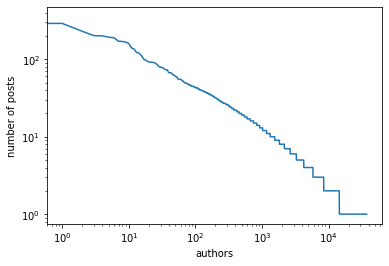

In [36]:
num_post_per_author = df_train['author'].value_counts().values

plt.plot(range(len(num_post_per_author)), num_post_per_author)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('number of posts')
plt.xlabel('authors')
plt.show()

In [37]:
author_posts = df_train['author'].value_counts()
author_posts.head()

fintechinshorts      358
nmstanley32          291
tiptoeintotown       230
BatSoup7519          202
Several_Meet_8653    201
Name: author, dtype: int64

In [38]:
def num_posts(author):
    if author in author_posts.index:
        out = author_posts[author]
    else:
        out = 1
    return out

df_train['num_posts'] = df_train['author'].apply(num_posts)
df_test['num_posts']  = df_test['author'].apply(num_posts)

<ipython-input-38-d0715e3caf88>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['num_posts'] = df_train['author'].apply(num_posts)
<ipython-input-38-d0715e3caf88>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['num_posts']  = df_test['author'].apply(num_posts)


In [39]:
author_scores = df_train.groupby('author').score.mean()
author_scores.head()

author
----The_Truth-----    107.83871
---Tsing__Tao---        1.00000
--GoldenFire--         37.50000
--Superb               15.25000
--Warmonger--           1.00000
Name: score, dtype: float64

In [40]:
# Fraction of newbie authors in the test set

count = 0
for author in df_test.author.unique():
    if author not in author_scores.index:
        count += 1

count/len(df_test)

0.32505191337881933

In [41]:
def mean_scores(author):
    if author in author_scores.index:
        out = author_scores[author]
    else:
        out = -99
    return out

df_train['mean_scores'] = df_train['author'].apply(mean_scores)
df_test['mean_scores']  = df_test['author'].apply(mean_scores)

<ipython-input-41-2283c3336a32>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['mean_scores'] = df_train['author'].apply(mean_scores)
<ipython-input-41-2283c3336a32>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['mean_scores']  = df_test['author'].apply(mean_scores)


In [42]:
no_newbie_index = df_test[df_test.mean_scores != -99].index

In [43]:
len(no_newbie_index)/len(df_test)

0.5142390981904479

In [44]:
median_score_newbie = df_train[df_train.num_posts == 1]['score'].median()

df_test.loc[df_test.mean_scores == -99, 'mean_scores'] = median_score_newbie

/Users/dutomo/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [45]:
#train_score = []
#test_score  = []

#for author in df_test.author.unique():
#    if author in author_scores.index:
#        
#        scores = df_train[df_train['author'] == author].score.values
#        time_length = 5. - df_train[df_train['author'] == author].posting_month
#        train_score.append(np.mean(scores/time_length))
#        
#        test_score.append(df_test[df_test['author'] == author].score.mean())

In [46]:
#score_ratio = np.array(train_score)/np.array(test_score)

#plt.hist(score_ratio, 100, (0,200))
#plt.yscale('log')
#plt.show()

## Preparing for modeling

In [47]:
X_train = df_train.drop(['popular', 'author', 'score', 'upvote_ratio', 'posting_year',
                         'tokens_title', 'tokens_body', 'title', 'body'], axis=1)

X_test  = df_test.drop(['popular', 'author', 'score', 'upvote_ratio', 'posting_year',
                         'tokens_title', 'tokens_body', 'title', 'body'], axis=1)

y_train = df_train['popular']
y_test  = df_test['popular']

X_train.head()

,pos_sent,neg_sent,neu_sent,comp_sent,posting_month,posting_date,posting_hour,posting_day_1,posting_day_2,posting_day_3,...,title_length,body_length,title_emoji,body_emoji,title_EQ,body_EQ,title_UL,body_UL,num_posts,mean_scores
0,0.000,0.0,1.000,0.0000,1,1,8.531389,0,0,0,...,18,0,6,0,0,0,0.051136,0.0,358,1.0
1,0.096,0.0,0.904,0.1531,1,1,11.524722,0,0,0,...,18,0,6,0,0,0,0.061611,0.0,358,1.0
2,0.000,0.0,1.000,0.0000,1,1,11.848333,0,0,0,...,7,0,0,0,0,0,0.000000,0.0,1,0.0
3,0.310,0.0,0.690,0.5574,1,1,13.878333,0,0,0,...,9,0,0,0,0,0,0.142857,0.0,1,7.0
4,0.000,0.0,1.000,0.0000,1,1,13.913333,0,0,0,...,6,0,0,0,0,0,0.033333,0.0,1,1.0


In [48]:
X_train.shape

(99226, 28)

In [49]:
X_train[y_train == 0].comp_sent.mean()

0.08230508124076809

In [50]:
X_train[y_train == 1].comp_sent.mean()

0.08717413405308141

In [51]:
X_test[y_test == 0].comp_sent.mean()

0.09625890334646453

In [52]:
X_test[y_test == 1].comp_sent.mean()

0.10469891126837236

## Making cross-validation data by time

In [53]:
jan_index = X_train[X_train.posting_month == 1].index
feb_index = X_train[X_train.posting_month == 2].index
mar_index = X_train[X_train.posting_month == 3].index
jan_feb_index = X_train[(X_train.posting_month == 1) | (X_train.posting_month == 2)].index

## Checking the variance of the data

In [54]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(X_train.describe())

           pos_sent      neg_sent      neu_sent     comp_sent  posting_month  \
count  99226.000000  99226.000000  99226.000000  99226.000000   99226.000000   
mean       0.104576      0.059750      0.835675      0.082523       2.358696   
std        0.167701      0.134915      0.201592      0.353650       0.708550   
min        0.000000      0.000000      0.000000     -0.991300       1.000000   
25%        0.000000      0.000000      0.708000      0.000000       2.000000   
50%        0.000000      0.000000      0.913000      0.000000       2.000000   
75%        0.184000      0.000000      1.000000      0.340000       3.000000   
max        1.000000      1.000000      1.000000      0.998200       3.000000   

       posting_date  posting_hour  posting_day_1  posting_day_2  \
count  99226.000000  99226.000000   99226.000000   99226.000000   
mean      16.394473     13.219304       0.174339       0.233880   
std        8.706470      5.628084       0.379403       0.423299   
min        

## Scaling the continuum features

In [55]:
from sklearn.preprocessing import StandardScaler

scaled_cols = ['posting_month','posting_date','posting_hour','title_length','body_length','title_emoji',
               'body_emoji','title_EQ','body_EQ','title_UL','body_UL','num_posts','mean_scores']

for col in scaled_cols:

    scaler = StandardScaler()

    X_train[col] = scaler.fit_transform(X_train[col].values.reshape(-1,1))
    X_test[col]  = scaler.transform(X_test[col].values.reshape(-1,1))

In [56]:
X_train.head()

,pos_sent,neg_sent,neu_sent,comp_sent,posting_month,posting_date,posting_hour,posting_day_1,posting_day_2,posting_day_3,...,title_length,body_length,title_emoji,body_emoji,title_EQ,body_EQ,title_UL,body_UL,num_posts,mean_scores
0,0.000,0.0,1.000,0.0000,-1.917582,-1.768174,-0.832955,0,0,0,...,0.437657,-0.311639,2.007405,-0.074429,-0.427492,-0.260983,-0.533108,-0.376108,8.726765,-0.234324
1,0.096,0.0,0.904,0.1531,-1.917582,-1.768174,-0.301095,0,0,0,...,0.437657,-0.311639,2.007405,-0.074429,-0.427492,-0.260983,-0.492719,-0.376108,8.726765,-0.234324
2,0.000,0.0,1.000,0.0000,-1.917582,-1.768174,-0.243596,0,0,0,...,-0.539047,-0.311639,-0.359630,-0.074429,-0.427492,-0.260983,-0.730275,-0.376108,-0.405571,-0.236495
3,0.310,0.0,0.690,0.5574,-1.917582,-1.768174,0.117097,0,0,0,...,-0.361465,-0.311639,-0.359630,-0.074429,-0.427492,-0.260983,-0.179460,-0.376108,-0.405571,-0.221297
4,0.000,0.0,1.000,0.0000,-1.917582,-1.768174,0.123316,0,0,0,...,-0.627838,-0.311639,-0.359630,-0.074429,-0.427492,-0.260983,-0.601751,-0.376108,-0.405571,-0.234324


In [57]:
X_test.head()

,pos_sent,neg_sent,neu_sent,comp_sent,posting_month,posting_date,posting_hour,posting_day_1,posting_day_2,posting_day_3,...,title_length,body_length,title_emoji,body_emoji,title_EQ,body_EQ,title_UL,body_UL,num_posts,mean_scores
1815,0.000,0.0,1.000,0.0000,2.316436,-1.768174,-1.090148,0,0,1,...,-0.627838,-0.311639,0.034876,-0.074429,-0.427492,-0.260983,-0.537489,-0.376108,-0.405571,-0.223469
1816,0.000,0.0,1.000,0.0000,2.316436,-1.768174,-1.044050,0,0,1,...,-0.183882,-0.311639,-0.359630,-0.074429,-0.427492,-0.260983,-0.022084,-0.376108,-0.405571,-0.223469
1817,0.470,0.0,0.530,0.7964,2.316436,-1.768174,-0.992818,0,0,1,...,-0.272673,-0.311639,-0.359630,-0.074429,-0.427492,-0.260983,-0.002783,-0.376108,0.080463,-0.234324
1818,0.000,0.0,1.000,0.0000,2.316436,-1.768174,-0.906742,0,0,1,...,-0.272673,-0.311639,-0.359630,-0.074429,-0.427492,-0.260983,0.103391,-0.376108,-0.405571,-0.234324
1819,0.343,0.0,0.657,0.8109,2.316436,-1.768174,-0.655471,0,0,1,...,0.704030,-0.311639,2.007405,-0.074429,-0.427492,-0.260983,-0.457649,-0.376108,8.726765,-0.234324


In [58]:
print(stop_now)

NameError: name 'stop_now' is not defined

# Modeling

## Logistic Regression

In [ ]:
from sklearn.metrics import precision_score, recall_score

cv1 = [jan_index, feb_index]
cv2 = [feb_index, mar_index]
cv3 = [jan_feb_index, mar_index]

cv = [cv1, cv2, cv3]

Cs = [0.1, 1, 10]
penalties = ['l1', 'l2']

prec_val = np.zeros((3,3,2)); prec_tr = np.zeros((3,3,2))
rec_val  = np.zeros((3,3,2)); rec_tr  = np.zeros((3,3,2))

for i in range(len(cv)):
    tr_index, val_index = cv[i]
    X_tr,  y_tr  = X_train.loc[tr_index],  y_train.loc[tr_index]
    X_val, y_val = X_train.loc[val_index], y_train.loc[val_index]
    
    for j in range(len(Cs)):
        for k in range(len(penalties)):
    
            logreg = LogisticRegression(max_iter=10000, C = Cs[j], penalty = penalties[k],
                                        solver='liblinear', class_weight='balanced')
            logreg.fit(X_tr, y_tr)
            
            y_tr_pred  = logreg.predict(X_tr)
            y_val_pred = logreg.predict(X_val)
            
            prec_tr[i,j,k]  = precision_score(y_tr, y_tr_pred)
            prec_val[i,j,k] = precision_score(y_val, y_val_pred)
            
            rec_tr[i,j,k]  = recall_score(y_tr, y_tr_pred)
            rec_val[i,j,k] = recall_score(y_val, y_val_pred)

In [ ]:
prec_tr.mean(axis=0)

In [ ]:
prec_val.mean(axis=0)

In [ ]:
rec_tr.mean(axis=0)

In [ ]:
rec_val.mean(axis=0)

In [ ]:
logreg = LogisticRegression(max_iter=10000, C = 0.1, penalty = 'l1',
                                        solver='liblinear', class_weight='balanced')
logreg.fit(X_train, y_train)

In [ ]:
y_pred = logreg.predict(X_train)
precision_recall_fscore_support(y_train, y_pred)

In [ ]:
y_pred = logreg.predict(X_test)
precision_recall_fscore_support(y_test, y_pred)

In [ ]:
from sklearn.metrics import plot_precision_recall_curve

fig, ax = plt.subplots(1,1, figsize=(7,5))
plot_precision_recall_curve(logreg, X_train, y_train, ax=ax, label='train')
plot_precision_recall_curve(logreg, X_test, y_test, ax=ax, label='test')
plt.grid(ls='--')
plt.legend(loc='upper right', fontsize=14)
plt.show()

In [ ]:
logreg = LogisticRegression(max_iter=10000, solver='liblinear', class_weight='balanced')
param_grid = {'C': [0.01,0.1,1,10],
              'penalty': ['l1','l2']}
gs = GridSearchCV(logreg, param_grid=param_grid) #, scoring='f1')
gs.fit(X_train, y_train)

In [ ]:
gs.best_params_

In [ ]:
gs.best_score_

In [ ]:
y_pred = gs.predict(X_train)
precision_recall_fscore_support(y_train, y_pred)

In [ ]:
y_pred = gs.predict(X_test)
precision_recall_fscore_support(y_test, y_pred)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(gs, X_test, y_test)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
plot_precision_recall_curve(gs, X_test, y_test, ax=ax)
plt.grid(ls='--')
plt.savefig('../../plots/prec_rec_curve_logreg.png')

In [ ]:
y_prob = gs.predict_proba(X_test)[:,1]
precision_recall_fscore_support(y_test, 1*(y_prob > 0.9))

In [ ]:
from joblib import dump, load
dump(gs, '../../saved_models/logreg.joblib')

## Random Forest

In [68]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=5)

#param_grid = {'max_depth': [5, 10, 20]}

#gs_rf = GridSearchCV(rfc, param_grid=param_grid)

rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5)

In [ ]:
gs_rf.best_params_

In [ ]:
y_pred_train = rfc.predict(X_train)
precision_recall_fscore_support(y_train, y_pred_train)

In [ ]:
y_pred_test = rfc.predict(X_test)
precision_recall_fscore_support(y_test, y_pred_test)

In [ ]:
y_pred_test = rfc.predict(X_test.loc[no_newbie_index])
precision_recall_fscore_support(y_test[no_newbie_index], y_pred_test)

In [ ]:
confusion_matrix(y_train, y_pred_train)

In [ ]:
confusion_matrix(y_test, y_pred_test)

In [ ]:
plot_roc_curve(gs_rf, X_test, y_test)

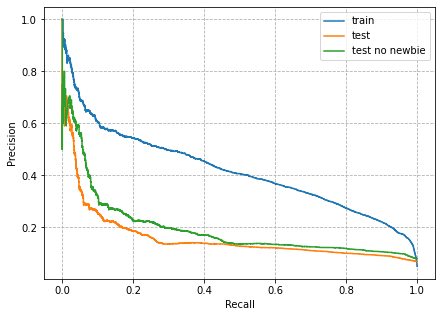

In [69]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
plot_precision_recall_curve(rfc, X_train, y_train, ax=ax, label='train')
plot_precision_recall_curve(rfc, X_test, y_test, ax=ax, label='test')
plot_precision_recall_curve(rfc, X_test.loc[no_newbie_index], y_test[no_newbie_index], ax=ax, label='test no newbie')
plt.grid(ls='--')
plt.legend(loc='upper right')
plt.show()

In [ ]:
prec = []
rec  = []
fscore = []

fig, ax = plt.subplots(1,1, figsize=(7,5))

for max_depth in [4, 5, 6]:

    rfc = RandomForestClassifier(class_weight='balanced', max_depth=max_depth)
    rfc.fit(X_train, y_train)
    
    #plot_precision_recall_curve(rfc, X_train, y_train, ax=ax, label='train %i' % max_depth)
    plot_precision_recall_curve(rfc, X_test, y_test, ax=ax, label='test %i' % max_depth)
    
    y_pred_test = rfc.predict(X_test)
    p, r, f, _ = precision_recall_fscore_support(y_test, y_pred_test)
    prec.append(p[1])
    rec.append(r[1])
    fscore.append(f[1])
    
plt.grid(ls='--')
plt.legend(loc='upper right')
plt.show()

In [ ]:
y_prob = gs.predict_proba(X_test)[:,1]
precision_recall_fscore_support(y_test, 1*(y_prob > 0.8))

In [ ]:
dump(gs_rf, '../../saved_models/rfc.joblib')

In [70]:
#feat_imp = gs_rf.best_estimator_.feature_importances_

feat_imp = rfc.feature_importances_

zipped_lists = zip(feat_imp, X_train.columns)

sorted_zipped_lists = sorted(zipped_lists)

sorted_columns  = [element for _, element in sorted_zipped_lists][::-1]
sorted_feat_imp = [element for element, _ in sorted_zipped_lists][::-1]

for i in range(len(sorted_columns)):
    print(sorted_columns[i], sorted_feat_imp[i])

mean_scores 0.7546743994857353
title_length 0.05232780805196799
body_length 0.05197883434141238
body_emoji 0.029603468506673922
ext_link_web 0.015090229809172632
body_EQ 0.013603715096331128
ext_link_media 0.012964174293004673
num_posts 0.008964278445718588
neu_sent 0.007888436088453682
posting_month 0.00770560296668291
subreddit_options 0.007401983385067669
neg_sent 0.007162588526777479
title_EQ 0.004741055340216837
body_UL 0.004705885981362296
posting_date 0.00427201412734895
pos_sent 0.003367906621466445
subreddit_pennystocks 0.0022819689350847975
posting_hour 0.002174003677975212
comp_sent 0.0020931906154099534
title_UL 0.0018009671613587021
posting_day_6 0.0013685630073541684
title_emoji 0.0011532085070385825
posting_day_5 0.0009674862232608806
posting_day_3 0.0006841087344683412
posting_day_2 0.0004796233135179053
posting_day_4 0.0003170251631952001
subreddit_finance 0.0001948898716983874
posting_day_1 3.258372224503061e-05


## XGBoost

In [ ]:
prec = []
rec  = []
fscore = []

fig, ax = plt.subplots(1,1, figsize=(7,5))

for max_depth in [4, 5, 6]:

    rfc = RandomForestClassifier(class_weight='balanced', max_depth=max_depth)
    rfc.fit(X_train, y_train)
    
    #plot_precision_recall_curve(rfc, X_train, y_train, ax=ax, label='train %i' % max_depth)
    plot_precision_recall_curve(rfc, X_test, y_test, ax=ax, label='test %i' % max_depth)
    
    y_pred_test = rfc.predict(X_test)
    p, r, f, _ = precision_recall_fscore_support(y_test, y_pred_test)
    prec.append(p[1])
    rec.append(r[1])
    fscore.append(f[1])
    
plt.grid(ls='--')
plt.legend(loc='upper right')
plt.show()

In [65]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=300, max_depth=1, scale_pos_weight=(len(y_train)/y_train.sum())-1, verbosity=0)

#param_grid = {'max_depth': [4, 5, 6],
#              'alpha': [1, 10, 100]}

#gs_xgb = GridSearchCV(xgb, param_grid=param_grid)

xgb.fit(X_train, y_train)

/Users/dutomo/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=21.31803868645974,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=0)

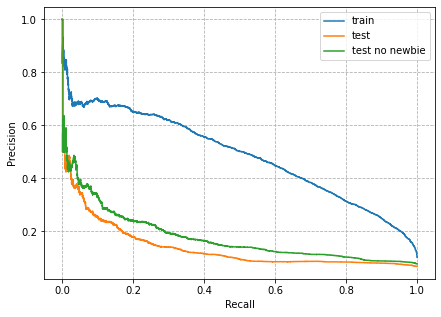

In [67]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
plot_precision_recall_curve(xgb, X_train, y_train, ax=ax, label='train')
plot_precision_recall_curve(xgb, X_test, y_test, ax=ax, label='test')
plot_precision_recall_curve(xgb, X_test.loc[no_newbie_index], y_test[no_newbie_index], ax=ax, label='test no newbie')
plt.grid(ls='--')
plt.legend(loc='upper right')
plt.savefig('../../plots/prec_rec_curve_xgb.png')
plt.show()

In [ ]:
gs_xgb.best_params_

In [ ]:
y_pred = gs_xgb.predict(X_train)
precision_recall_fscore_support(y_train, y_pred)

In [ ]:
y_pred = gs_xgb.predict(X_test)
precision_recall_fscore_support(y_test, y_pred)

In [ ]:
plot_roc_curve(gs_xgb, X_test, y_test)

## Neural network

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.metrics import binary_accuracy, Recall, BinaryAccuracy

In [ ]:
def build_network(n_features, n_output, n_layers=1, n_nodes=10, activ_func='relu', dropout_rate=0.):
    ''' Building neural network model '''
    model = Sequential()
    model.add(Dense(n_nodes, activation=activ_func, use_bias=True, input_shape=(n_features,)))
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation=activ_func, use_bias=True))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate, input_shape=(n_nodes,)))
    model.add(Dense(n_output, activation='sigmoid'))
    return model

In [ ]:
def fit_network(X, y, n_output, n_layers=1, n_nodes=10, activ_func='relu', dropout_rate=0., epochs=10,
                metrics=[binary_accuracy], loss_weights=None, patience=5):
    # Building neural network model
    n_features = np.shape(X)[1]
    model = build_network(n_features, n_output, n_layers, n_nodes, activ_func, dropout_rate)
    # Compiling model
    early_stopping_monitor = EarlyStopping(patience=patience)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics, loss_weights=loss_weights)
    # Fitting model
    history = model.fit(X, y,
                        validation_split=0.2, epochs=epochs,
                        shuffle=True, callbacks=[early_stopping_monitor])
    return model, history

In [ ]:
model, history = fit_network(X_train, y_train, n_output=1, n_layers=2, n_nodes=10, epochs=30, patience=3,
                             loss_weights=[1, 100.])

In [ ]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
y_prob = model.predict(X_train)
precision_recall_fscore_support(y_train, 1*(y_prob > 0.5))

In [ ]:
y_prob = model.predict(X_test)
precision_recall_fscore_support(y_test, 1*(y_prob > 0.5))

In [ ]:
from sklearn.metrics import precision_score, recall_score

thres = np.arange(0,1,0.01)

prec_nn = []
rec_nn = []

for t in thres:
    prec_nn.append(precision_score(y_test, 1*(y_prob > t)))
    rec_nn.append(recall_score(y_test, 1*(y_prob > t)))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
plot_precision_recall_curve(gs, X_test, y_test, ax=ax, label='logistic regression')
plot_precision_recall_curve(gs_rf, X_test, y_test, ax=ax, label='random forest')
plot_precision_recall_curve(gs_xgb, X_test, y_test, ax=ax, label='XGBoost')
ax.plot(rec_nn, prec_nn, label='neural network')
plt.grid(ls='--')
plt.legend(loc='upper right')
plt.savefig('../../plots/prec_rec_curve.png')